## Mask R-CNN

Credits to Pytorch Mask R-CNN documentation:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

### Latex Detection -> Image to Latex Pipeline
1. Upload an image scan
2. Draw a bounding box any latex
3. Crop the bounding box into an image
4. Export both the cropped images in a folder along with bounding box coordinates
5. Image to latex pipeline turns each cropped image into a latex translation
6. Output side by side for each cropped image the latex translation

### Installation/Dependencies:


In [4]:
%load_ext autoreload
%autoreload 2

import os
import torch 
import requests
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import masks_to_boxes, box_convert


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# use the mobilenet for mobile detection
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT)
num_classes = 1

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [6]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [7]:
# sample dataset

class LatexBoundingBoxDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = []
        self.masks = []

    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)

    def __len__(self):
        return len(self.imgs)

Let's try this once.

In [8]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
# TODO: change to use the actual dataset
dataset = LatexBoundingBoxDataset('data/LatexBoundingBoxDataset', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
# TODO: change to load an image that we want to test
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

ModuleNotFoundError: No module named 'utils'

Let's run the training loop!

In [ ]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - bounding box box or not 
num_classes = 2
# use our dataset and defined transformations
# TODO: use the actual folder where the data is
dataset = LatexBoundingBoxDataset('data/LatexBoundingBoxDataset', get_transform(train=True))
dataset_test = LatexBoundingBoxDataset('data/LatexBoundingBoxDataset', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

ModuleNotFoundError: No module named 'engine'

Test the implementation!

/Users/maxin/Library/Python/3.9/lib/python/site-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


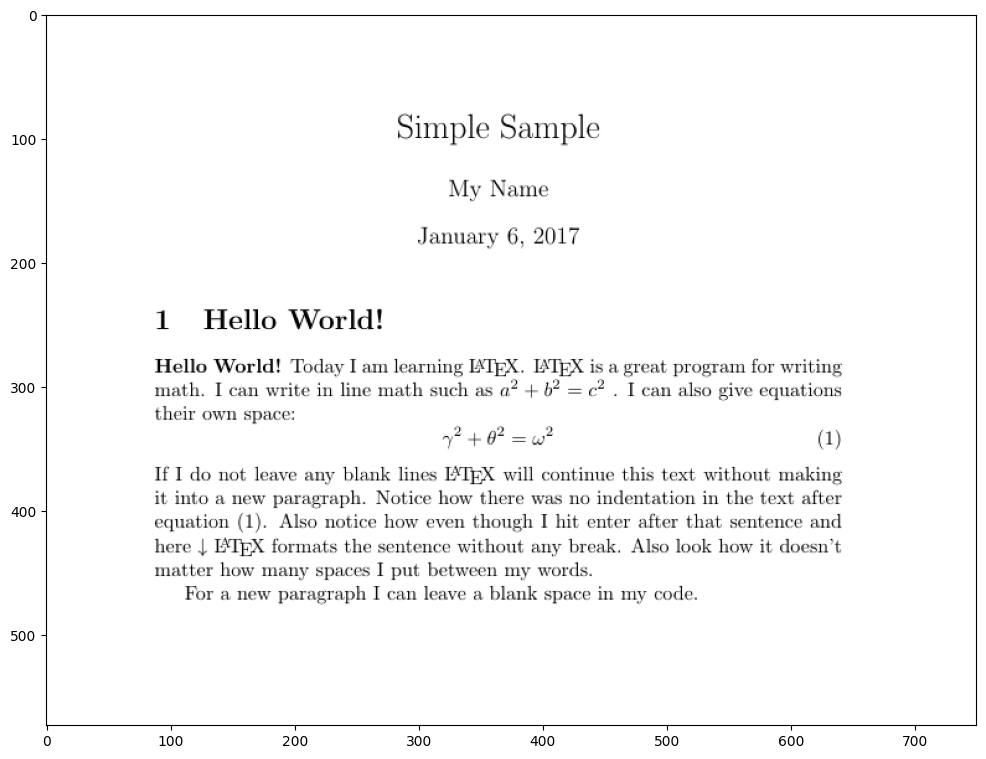

In [13]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

test_img = "../images/latex_seg.png"
image = read_image(test_img)
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image) # convert RGBA -> RGB and move to device
    x = x[:3, ...]
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))